# n호가 선정 과정
- 메모리 오류를 방지하기 위해 데이터 용량을 줄여야 한다.
- 원본 호가창 데이터의 매도 잔량(i_ask_size)과 매수 잔량(i_bid_size)의 값의 변화율을 보면서 n호가까지만 선정하려고 한다.

In [1]:
import glob
import os #작업 디렉토리 설정에 사용
import json #파일 불러오기에 사용
import re #파일 경로에서 날짜 정보만 추출할 때 사용
import time #총 실행시간 확인용
from tqdm import tqdm #진행률 표시

#넘파이 판다스 라이브러리
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)

#시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt

# (1) 데이터 불러오기

In [3]:
### [함수 1] 데이터 불러오기
def load_json_to_dataframe(file_path):
  #JSON 데이터를 담을 리스트 초기화
  data_list = []

  #파일을 한 줄씩 읽고 JSON 객체로 변환하여 리스트에 추가
  with open(file_path, 'r') as f:
      for line in f:
          try:
              #JSON 객체로 변환 (단일 따옴표를 이중 따옴표로 변경)
              data = json.loads(line.strip().replace("'", '"'))
              data_list.append(data)
          except json.JSONDecodeError as e: #오류발생 시 메세지 출력
              print(f"Error decoding JSON in file {file_path}: {e}")

  #JSON 데이터를 데이터프레임으로 변환
  df = pd.DataFrame(data_list)
  return df


### [함수 2] orderbook_units의 값들을 열로 펼치기
def expand_orderbook_units(row, max_units=15):
  new_columns = {} #딕셔너리 초기화

  for i in range(max_units):
      try:
          unit = row['orderbook_units'][i]
          new_columns[f'{i+1}_ask_price'] = unit['ask_price']
          new_columns[f'{i+1}_bid_price'] = unit['bid_price']
          new_columns[f'{i+1}_ask_size'] = unit['ask_size']
          new_columns[f'{i+1}_bid_size'] = unit['bid_size']
      except IndexError:
          # 만약 딕셔너리 개수가 부족하면 None으로 채움
          new_columns[f'{i+1}_ask_price'] = None
          new_columns[f'{i+1}_bid_price'] = None
          new_columns[f'{i+1}_ask_size'] = None
          new_columns[f'{i+1}_bid_size'] = None
  return pd.Series(new_columns)


### [함수 3] 호가창 데이터에 대한 전처리 함수 생성
#이 함수에서 [함수 1]과 [함수 2]가 사용됨
def ord_preprocessing(ord_file_path):
    
    ##### (1) 데이터 불러오기 ##### ------------------------------------------------
    
    ### 호가창 데이터 불러오기
    df = load_json_to_dataframe(ord_file_path)
    
    ### 호가창 데이터에서 불필요한 열 제거
    df = df.drop(["market", "level"], axis=1)
    
    
    ##### (2) 데이터 전처리 ##### --------------------------------------------------
    
    ### timestamp를 기준으로 중복행 제거
    df = df.drop_duplicates(subset = ["timestamp"]).reset_index(drop = True) #호가창 데이터
    
    ### 결측치 제거
    df = df.dropna(axis=0).reset_index(drop=True)
    
    ### orderbook_units의 딕셔너리 값 열로 펼치기
    df = df.join(df.apply(expand_orderbook_units, axis=1)).drop(columns=['orderbook_units'])

    ### i_ask_size와 i_bid_size만 선택
    df = df[[f'{i+1}_ask_size' for i in range(15)] + [f'{i+1}_bid_size' for i in range(15)]]

    return df

In [4]:
#데이터 불러오기
# 호가창 데이터 파일들이 저장된 경로
ord_folder_path = '../data/orderbook'

# 50개의 호가창 데이터 파일을 불러오기
ord_files = [os.path.join(ord_folder_path, f) for f in os.listdir(ord_folder_path)]

# 결과를 저장할 빈 리스트
df_list = []

# 진행률 표시와 시간 계산
start_time = time.time()

# tqdm으로 진행률 표시
for file in tqdm(ord_files, desc="Processing files", unit="file"):
    try:
        # 각 파일에 대해 ord_preprocessing 함수 적용
        df_processed = ord_preprocessing(file)
        df_list.append(df_processed)
    except Exception as e:
        print(f"Error processing {file}: {e}")

# 모든 데이터프레임 합치기
df = pd.concat(df_list, ignore_index=True)

# 전체 걸린 시간 계산
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Processing completed in {elapsed_time:.2f} seconds")

Processing files: 100%|████████████████████████████████████████████████████████████| 50/50 [1:15:45<00:00, 90.92s/file]


Processing completed in 4556.84 seconds


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8540811 entries, 0 to 8540810
Data columns (total 30 columns):
 #   Column       Dtype  
---  ------       -----  
 0   1_ask_size   float64
 1   2_ask_size   float64
 2   3_ask_size   float64
 3   4_ask_size   float64
 4   5_ask_size   float64
 5   6_ask_size   float64
 6   7_ask_size   float64
 7   8_ask_size   float64
 8   9_ask_size   float64
 9   10_ask_size  float64
 10  11_ask_size  float64
 11  12_ask_size  float64
 12  13_ask_size  float64
 13  14_ask_size  float64
 14  15_ask_size  float64
 15  1_bid_size   float64
 16  2_bid_size   float64
 17  3_bid_size   float64
 18  4_bid_size   float64
 19  5_bid_size   float64
 20  6_bid_size   float64
 21  7_bid_size   float64
 22  8_bid_size   float64
 23  9_bid_size   float64
 24  10_bid_size  float64
 25  11_bid_size  float64
 26  12_bid_size  float64
 27  13_bid_size  float64
 28  14_bid_size  float64
 29  15_bid_size  float64
dtypes: float64(30)
memory usage: 1.9 GB


# (2) 매도와 매수 잔량의 사분위 그래프

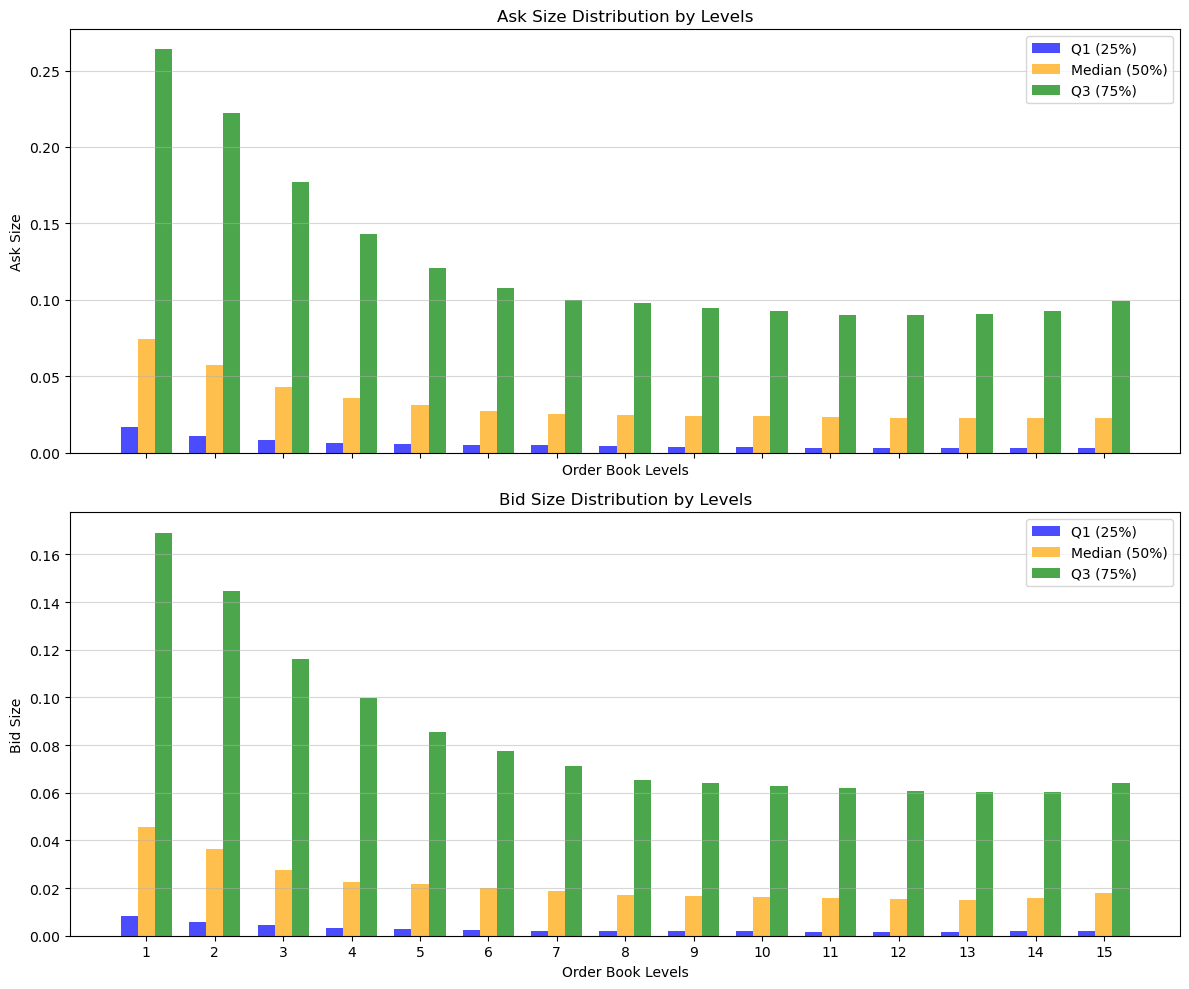

In [15]:
# 매도 잔량의 분위값 계산
ask_q1 = [df[f"{i}_ask_size"].quantile(0.25) for i in range(1, 16)]
ask_median = [df[f"{i}_ask_size"].median() for i in range(1, 16)]
ask_q3 = [df[f"{i}_ask_size"].quantile(0.75) for i in range(1, 16)]

# 매수 잔량의 분위값 계산
bid_q1 = [df[f"{i}_bid_size"].quantile(0.25) for i in range(1, 16)]
bid_median = [df[f"{i}_bid_size"].median() for i in range(1, 16)]
bid_q3 = [df[f"{i}_bid_size"].quantile(0.75) for i in range(1, 16)]

# x축 호가 단계
levels = np.arange(1, 16)  # 1 ~ 15

# 그래프 그리기
width = 0.25  # 막대 폭
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# 매도 잔량 막대 그래프
axs[0].bar(levels - width, ask_q1, width, label='Q1 (25%)', color='blue', alpha=0.7)
axs[0].bar(levels, ask_median, width, label='Median (50%)', color='orange', alpha=0.7)
axs[0].bar(levels + width, ask_q3, width, label='Q3 (75%)', color='green', alpha=0.7)
axs[0].set_title('Ask Size Distribution by Levels')
axs[0].set_xlabel('Order Book Levels')
axs[0].set_ylabel('Ask Size')
axs[0].set_xticks(levels)
axs[0].legend()
axs[0].grid(axis='y', alpha=0.5)

# 매수 잔량 막대 그래프
axs[1].bar(levels - width, bid_q1, width, label='Q1 (25%)', color='blue', alpha=0.7)
axs[1].bar(levels, bid_median, width, label='Median (50%)', color='orange', alpha=0.7)
axs[1].bar(levels + width, bid_q3, width, label='Q3 (75%)', color='green', alpha=0.7)
axs[1].set_title('Bid Size Distribution by Levels')
axs[1].set_xlabel('Order Book Levels')
axs[1].set_ylabel('Bid Size')
axs[1].set_xticks(levels)
axs[1].legend()
axs[1].grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

# (3) 매도와 매수 잔량 사분위의 변화율 계산

In [17]:
# 변화율 계산 함수
def calculate_change_rates(values):
    return [abs(values[i] - values[i - 1]) / values[i - 1] * 100 if values[i - 1] != 0 else 0 
            for i in range(1, len(values))]

# 매도 잔량의 변화율 계산 (Q1, Median, Q3)
ask_q1_changes = calculate_change_rates(ask_q1)
ask_median_changes = calculate_change_rates(ask_median)
ask_q3_changes = calculate_change_rates(ask_q3)

# 매수 잔량의 변화율 계산 (Q1, Median, Q3)
bid_q1_changes = calculate_change_rates(bid_q1)
bid_median_changes = calculate_change_rates(bid_median)
bid_q3_changes = calculate_change_rates(bid_q3)

# (4) 퍼센트 변화율 기반의 임계값

In [20]:
# 특정 임계값 설정 (예: 변화율 n% 이하로 떨어지는 시점)
threshold = 20

# 매도와 매수에서 가장 먼저 변화율이 임계값 이하로 떨어지는 호가 레벨 찾기
def find_stable_level(changes, threshold):
    for i, change in enumerate(changes):
        if change <= threshold:
            return i + 2  # 변화율은 2번째 호가부터 계산되므로 +2
    return len(changes) + 1  # 모든 변화율이 threshold 이상인 경우

# 매도 잔량의 안정적인 호가 레벨 찾기
ask_q1_level = find_stable_level(ask_q1_changes, threshold)
ask_median_level = find_stable_level(ask_median_changes, threshold)
ask_q3_level = find_stable_level(ask_q3_changes, threshold)

# 매수 잔량의 안정적인 호가 레벨 찾기
bid_q1_level = find_stable_level(bid_q1_changes, threshold)
bid_median_level = find_stable_level(bid_median_changes, threshold)
bid_q3_level = find_stable_level(bid_q3_changes, threshold)

# 결과 출력
print(f'임계값이 {threshold}일 때,')
print(f"Ask Size Stable Levels: Q1 = {ask_q1_level}, Median = {ask_median_level}, Q3 = {ask_q3_level}")
print(f"Bid Size Stable Levels: Q1 = {bid_q1_level}, Median = {bid_median_level}, Q3 = {bid_q3_level}")

임계값이 20일 때,
Ask Size Stable Levels: Q1 = 5, Median = 4, Q3 = 2
Bid Size Stable Levels: Q1 = 5, Median = 4, Q3 = 2


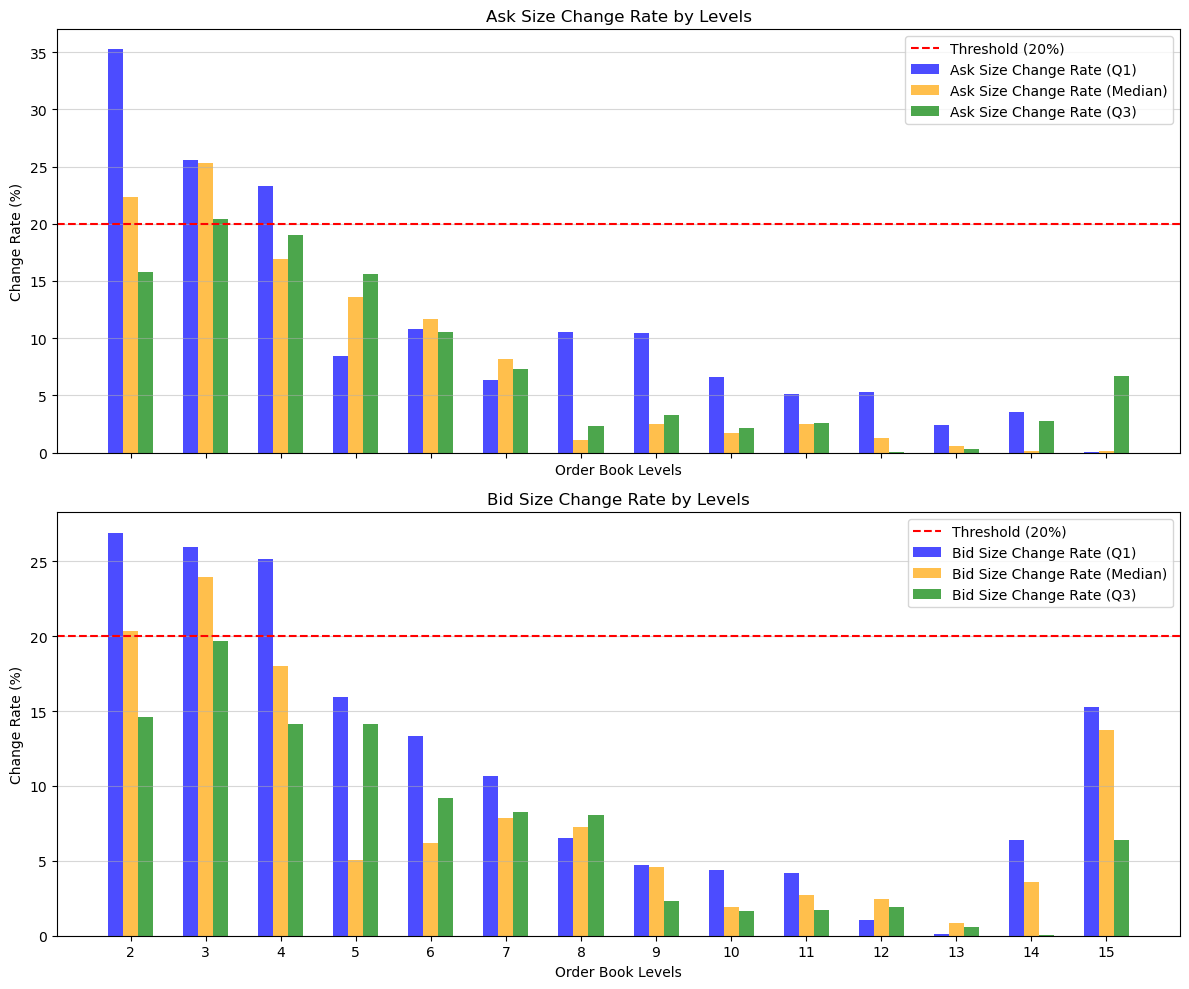

In [31]:
# x축 값 (i-1에서 i 호가로 넘어갈 때의 변화율을 보니까)
x_values = np.arange(2, 16)
                    
# 변화율 그래프 그리기
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# 매도 잔량 변화율 막대 그래프 (Q1, Median, Q3)
axs[0].bar(x_values - 0.2, ask_q1_changes, width=0.2, color='blue', alpha=0.7, label='Ask Size Change Rate (Q1)')
axs[0].bar(x_values, ask_median_changes, width=0.2, color='orange', alpha=0.7, label='Ask Size Change Rate (Median)')
axs[0].bar(x_values + 0.2, ask_q3_changes, width=0.2, color='green', alpha=0.7, label='Ask Size Change Rate (Q3)')
axs[0].axhline(threshold, color='red', linestyle='--', label=f'Threshold ({threshold}%)')  # 임계값 선 추가
axs[0].set_title('Ask Size Change Rate by Levels')
axs[0].set_xlabel("Order Book Levels")
axs[0].set_ylabel('Change Rate (%)')
axs[0].set_xticks(x_values)
axs[0].legend()
axs[0].grid(axis='y', alpha=0.5)

# 매수 잔량 변화율 막대 그래프 (Q1, Median, Q3)
axs[1].bar(x_values - 0.2, bid_q1_changes, width=0.2, color='blue', alpha=0.7, label='Bid Size Change Rate (Q1)')
axs[1].bar(x_values, bid_median_changes, width=0.2, color='orange', alpha=0.7, label='Bid Size Change Rate (Median)')
axs[1].bar(x_values + 0.2, bid_q3_changes, width=0.2, color='green', alpha=0.7, label='Bid Size Change Rate (Q3)')
axs[1].axhline(threshold, color='red', linestyle='--', label=f'Threshold ({threshold}%)')  # 임계값 선 추가
axs[1].set_title('Bid Size Change Rate by Levels')
axs[1].set_xlabel('Order Book Levels')
axs[1].set_ylabel('Change Rate (%)')
axs[1].set_xticks(x_values)
axs[1].legend()
axs[1].grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

# (5) 사분위수 기반의 임계값

In [41]:
#IQR 계산
ask_Q1 = np.percentile(ask_q1_changes, 25)
ask_Q3 = np.percentile(ask_q3_changes, 75)
ask_IQR = ask_Q3 - ask_Q1

bid_Q1 = np.percentile(bid_q1_changes, 25)
bid_Q3 = np.percentile(bid_q3_changes, 75)
bid_IQR = bid_Q3 - bid_Q1

# 임계값을 Q3 + 1.5 * IQR로 설정
ask_threshold = round(ask_Q3 + 1.5 * ask_IQR, 2)
bid_threshold = round(bid_Q3 + 1.5 * bid_IQR, 2)

# 매도와 매수에서 가장 먼저 변화율이 임계값 이하로 떨어지는 호가 레벨 찾기
def find_stable_level(changes, threshold):
    for i, change in enumerate(changes):
        if change <= threshold:
            return i + 2  # 변화율은 2번째 호가부터 계산되므로 +2
    return len(changes) + 1  # 모든 변화율이 threshold 이상인 경우

# 매도 잔량의 안정적인 호가 레벨 찾기
ask_q1_level = find_stable_level(ask_q1_changes, ask_threshold)
ask_median_level = find_stable_level(ask_median_changes, ask_threshold)
ask_q3_level = find_stable_level(ask_q3_changes, ask_threshold)

# 매수 잔량의 안정적인 호가 레벨 찾기
bid_q1_level = find_stable_level(bid_q1_changes, bid_threshold)
bid_median_level = find_stable_level(bid_median_changes, bid_threshold)
bid_q3_level = find_stable_level(bid_q3_changes, bid_threshold)

# 결과 출력
print(f'매도 잔량의 임계값이 {ask_threshold}일 때,')
print(f"Ask Size Stable Levels: Q1 = {ask_q1_level}, Median = {ask_median_level}, Q3 = {ask_q3_level}")
print(f'매수 잔량의 임계값이 {bid_threshold}일 때,')
print(f"Bid Size Stable Levels: Q1 = {bid_q1_level}, Median = {bid_median_level}, Q3 = {bid_q3_level}")

매도 잔량의 임계값이 26.19일 때,
Ask Size Stable Levels: Q1 = 3, Median = 2, Q3 = 2
매수 잔량의 임계값이 23.52일 때,
Bid Size Stable Levels: Q1 = 5, Median = 2, Q3 = 2


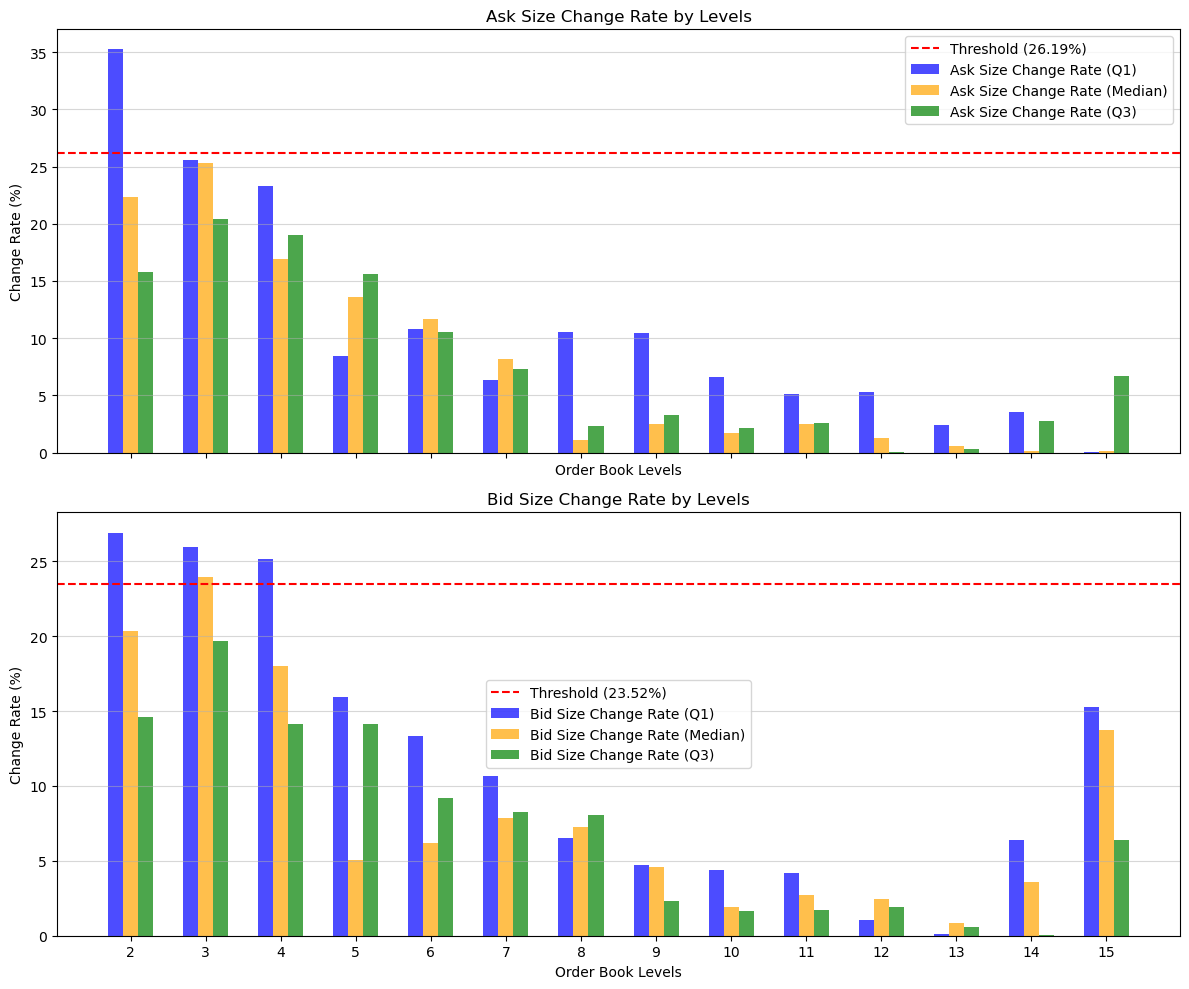

In [43]:
# x축 값 (i-1에서 i 호가로 넘어갈 때의 변화율을 보니까)
x_values = np.arange(2, 16)
                    
# 변화율 그래프 그리기
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# 매도 잔량 변화율 막대 그래프 (Q1, Median, Q3)
axs[0].bar(x_values - 0.2, ask_q1_changes, width=0.2, color='blue', alpha=0.7, label='Ask Size Change Rate (Q1)')
axs[0].bar(x_values, ask_median_changes, width=0.2, color='orange', alpha=0.7, label='Ask Size Change Rate (Median)')
axs[0].bar(x_values + 0.2, ask_q3_changes, width=0.2, color='green', alpha=0.7, label='Ask Size Change Rate (Q3)')
axs[0].axhline(ask_threshold, color='red', linestyle='--', label=f'Threshold ({ask_threshold}%)')  # 임계값 선 추가
axs[0].set_title('Ask Size Change Rate by Levels')
axs[0].set_xlabel('Order Book Levels')
axs[0].set_ylabel('Change Rate (%)')
axs[0].set_xticks(x_values)
axs[0].legend()
axs[0].grid(axis='y', alpha=0.5)

# 매수 잔량 변화율 막대 그래프 (Q1, Median, Q3)
axs[1].bar(x_values - 0.2, bid_q1_changes, width=0.2, color='blue', alpha=0.7, label='Bid Size Change Rate (Q1)')
axs[1].bar(x_values, bid_median_changes, width=0.2, color='orange', alpha=0.7, label='Bid Size Change Rate (Median)')
axs[1].bar(x_values + 0.2, bid_q3_changes, width=0.2, color='green', alpha=0.7, label='Bid Size Change Rate (Q3)')
axs[1].axhline(bid_threshold, color='red', linestyle='--', label=f'Threshold ({bid_threshold}%)')  # 임계값 선 추가
axs[1].set_title('Bid Size Change Rate by Levels')
axs[1].set_xlabel('Order Book Levels')
axs[1].set_ylabel('Change Rate (%)')
axs[1].set_xticks(x_values)
axs[1].legend()
axs[1].grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

- 호가창 데이터는 일부 호가에서 급격한 변동이 발생할 수 있다. 즉, 데이터의 분포가 불균형하므로 매도와 매수 잔량의 분포가 사분위수(q1, median, q3)에 따라서 어떻게 변화하는지를 본다. (사분위수를 통한 변화율 탐지 방법이 불균형한 분포나 이상치에 영향을 덜 받음)
- 사분위수 분포를 살펴봄으로써 각 경우에서의 변화를 더 잘 살펴볼 수 있다.
- 각 호가 레벨에서 변화율이 특정 임계값 이하로 떨어지는 시점(=변화율이 충분히 작아 더 이상 큰 변화가 없는 시점)을 찾는다.
- 사분위수 기반의 임계값을 사용한 결과, 매도 잔량에서는 3호가, 매수 잔량에서는 5호가 이후부터는 큰 변화가 없다고 판단되었다.
- 결론적으로, 매도 잔량과 매수 잔량 모든 경우를 고려하면 5호가까지만 데이터의 분포 변화율이 유의하므로 5호가까지만 선택하기로 결정하였다.